In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
print(model)

Using cpu device


Using cache found in /Users/yuhei/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
affine = T.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = T.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = T.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = T.ToTensor()

transform_train = T.Compose([affine, flip, to_tensor, normalize])
transform_test = T.Compose([to_tensor, normalize])

# 訓練データをdatasetsからダウンロード
training_data = datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform_train,
)

# テストデータをdatasetsからダウンロード
test_data = datasets.CIFAR10(
    root="../data",
    train=False,
    download=True,
    transform=transform_test,
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 1.528403  [    0/50000]
loss: 1.344792  [ 6400/50000]
loss: 1.354221  [12800/50000]
loss: 1.226966  [19200/50000]
loss: 1.303598  [25600/50000]
loss: 1.104667  [32000/50000]
loss: 1.174281  [38400/50000]
loss: 1.325850  [44800/50000]
Test Error: 
 Accuracy: 53.7%, Avg loss: 0.020306 

Epoch 2
-------------------------------
loss: 1.400231  [    0/50000]
loss: 1.216425  [ 6400/50000]
loss: 1.239778  [12800/50000]
loss: 1.317834  [19200/50000]
loss: 1.357574  [25600/50000]
loss: 1.392288  [32000/50000]
loss: 1.215399  [38400/50000]
loss: 1.284158  [44800/50000]
Test Error: 
 Accuracy: 56.8%, Avg loss: 0.019030 

Epoch 3
-------------------------------
loss: 1.458811  [    0/50000]
loss: 1.339039  [ 6400/50000]
loss: 1.290657  [12800/50000]
loss: 1.252893  [19200/50000]
loss: 1.325230  [25600/50000]
loss: 1.319819  [32000/50000]
loss: 1.197524  [38400/50000]
loss: 1.144505  [44800/50000]
Test Error: 
 Accuracy: 58.8%, Avg loss: 0.018407 

Epoc

In [11]:
# モデルの保存
PATH = '../model/resnet_cifar.pth'
torch.save(model.state_dict(), PATH)

GroundTruth : Predicted
deer  : deer  o
plane : car   x
plane : plane o
dog   : bird  x
plane : cat   x
frog  : frog  o
bird  : frog  x
plane : plane o
cat   : dog   x
car   : car   o
car   : car   o
plane : plane o
frog  : frog  o
dog   : dog   o
dog   : dog   o
plane : plane o
deer  : horse x
plane : ship  x
cat   : cat   o
frog  : frog  o
cat   : cat   o
ship  : ship  o
cat   : truck x
cat   : plane x
bird  : bird  o
bird  : frog  x
cat   : frog  x
cat   : frog  x
ship  : ship  o
cat   : truck x
ship  : ship  o
cat   : dog   x
car   : car   o
deer  : deer  o
ship  : ship  o
frog  : deer  x
horse : truck x
car   : car   o
deer  : deer  o
cat   : dog   x
ship  : ship  o
horse : horse o
ship  : ship  o
plane : plane o
dog   : horse x
plane : plane o
deer  : frog  x
truck : truck o
ship  : ship  o
bird  : bird  o
bird  : bird  o
deer  : dog   x
horse : horse o
plane : plane o
ship  : ship  o
bird  : deer  x
car   : car   o
bird  : horse x
deer  : deer  o
cat   : dog   x
dog   : horse x


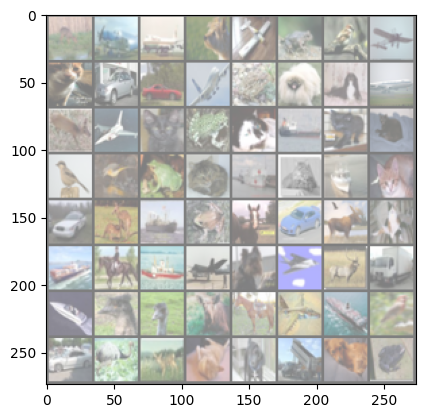

In [13]:
# テストデータでの評価
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# model = CNN()
# 保存した状態辞書をロード
model.load_state_dict(torch.load('../model/resnet_cifar.pth'))
model.eval()

# 画像の表示
def imshow(img):
    img = img / 2 + 0.5     # デノーマライズ
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')  # 軸を非表示にする
    plt.show()

# 出力の表示
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)
print("GroundTruth : Predicted")
for j in range(batch_size):
    if classes[labels[j]] == classes[predicted[j]]:
        judge = "o"
    else:
        judge = "x"
    print("{} : {} {}".format(f'{classes[labels[j]]:5s}',f'{classes[predicted[j]]:5s}',judge))
    

    # print('GroundTruth:  ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    # print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

# 画像を表示
imshow(torchvision.utils.make_grid(images))